In [81]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

## Read in Data

The files have already been preprocessed in R in `utils.R`

Those were the parts for 1.1 and 1.2

In [69]:
biogrid_lcc = pd.read_csv("Files/Biogrid.txt", sep='\t')
huri_lcc = pd.read_csv("Files/Huri.txt", sep='\t')
string_lcc = pd.read_csv("Files/String.txt", sep='\t')
reactome_lcc = pd.read_csv("Files/Reactome.txt", sep='\t')

interactomes_lcc = [biogrid_lcc, huri_lcc, string_lcc, reactome_lcc]

disease = pd.read_csv("Files/Cardiomyopathy.txt").iloc[:,0].tolist()

In [70]:
biogrid_lcc.head()

,GeneA,GeneB
0,MAP2K4,FLNC
1,MYPN,ACTN2
2,ACVR1,FNTA
3,GATA2,PML
4,RPA2,STAT3


Build graph of interactome LCC size to find all the nodes and links (not just disease)

In [71]:
def create_graph(df, name):
    """
    Function th create graph

    Params :
    - df : the interactome
    - name : name of the graph

    Returns : instance of nxGraph
    """
    # Create instance of graph
    graph = nx.Graph(name = name)

    edges = []
    for i in range(0,df.shape[0]):
        # For each row, we add it as an edge
        edges.append((df.iloc[i,0],df.iloc[i,1]))
    
    # Get list of *unique* genes among "GeneA" and "GeneB" columns
    nodes = list(set(df["GeneA"]) | set(df["GeneB"]))

    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    return graph

In [ ]:
print("Running for ~3 minutes...")

biogrid_lcc_graph = create_graph(biogrid_lcc, "biogrid_interactions")
huri_lcc_graph = create_graph(huri_lcc, "huri_interactions")
string_lcc_graph = create_graph(string_lcc, "string_interactions")
reactome_lcc_graph = create_graph(reactome_lcc, "reactome_interactions")

### 1.3. Compute and characterize the disease LCC 

1.3.1 Check for the presence of disease genes in the LCCs of each interactome
(as from point 1.1) and identify the disease interactomes by getting the
interactions among disease genes

In [ ]:
# 1. We get the set of disease genes included in "GeneA" and "GeneB" for each interactome
# 2. Then we create a new "sub-interactome" made only of disease genes interactions

biogrid_filter = biogrid_lcc["GeneA"].isin(disease) & biogrid_lcc["GeneB"].isin(disease)
biogrid_disease_interactions = biogrid_lcc[biogrid_filter].reset_index(drop=True)

huri_filter = huri_lcc["GeneA"].isin(disease) & huri_lcc["GeneB"].isin(disease)
huri_disease_interactions = huri_lcc[huri_filter].reset_index(drop=True)

string_filter = string_lcc["GeneA"].isin(disease) & string_lcc["GeneB"].isin(disease)
string_disease_interactions = string_lcc[string_filter].reset_index(drop=True)

reactome_filter = reactome_lcc["GeneA"].isin(disease) & reactome_lcc["GeneB"].isin(disease)
reactome_disease_interactions = reactome_lcc[reactome_filter].reset_index(drop=True)

In [38]:
# We create a specific graph for the diseases interactions
biogrid_disease_graph = create_graph(biogrid_disease_interactions, "biogrid_disease_interactions")
huri_disease_graph = create_graph(huri_disease_interactions, "huri_disease_interactions")
string_disease_graph = create_graph(string_disease_interactions, "string_disease_interactions")
reactome_disease_graph = create_graph(reactome_disease_interactions, "reactome_disease_interactions")

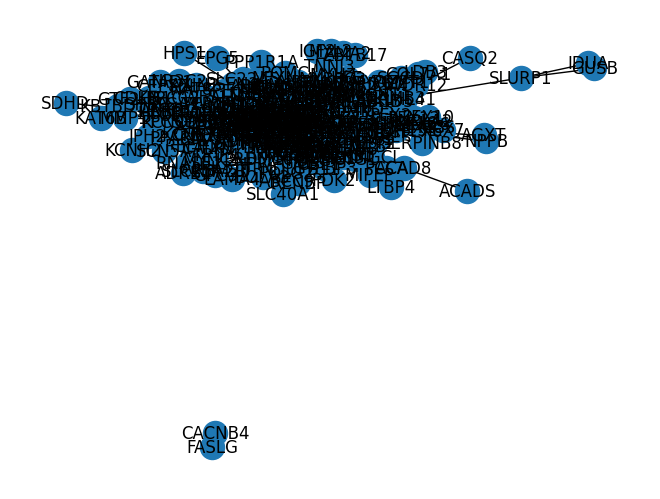

In [48]:
## Visualizing Biogrid disease graph
nx.draw(biogrid_disease_graph, with_labels=True)
plt.show()

1.3.2 Summarize the Interactome and GDA-related data as in table 1

### Stella : here you can factorize with for loop :)

In [73]:
table1_dict = {
    'biogrid': {},
    'huri': {},
    'string': {},
    'reactome': {}
}

# 1. Get the size of the original interactome
table1_dict["biogrid"]["nodes_edges"] = (biogrid_lcc_graph.number_of_nodes(), biogrid_lcc_graph.number_of_edges())
table1_dict["huri"]["nodes_edges"] = (huri_lcc_graph.number_of_nodes(), huri_lcc_graph.number_of_edges())
table1_dict["string"]["nodes_edges"] = (string_lcc_graph.number_of_nodes(), string_lcc_graph.number_of_edges())
table1_dict["reactome"]["nodes_edges"] = (reactome_lcc_graph.number_of_nodes(), reactome_lcc_graph.number_of_edges())

# 2. Get the number of unique disease genes present in the interactome
table1_dict["biogrid"]["nbr_disease_genes"] = biogrid_disease_graph.number_of_nodes()
table1_dict["huri"]["nbr_disease_genes"] = huri_disease_graph.number_of_nodes()
table1_dict["string"]["nbr_disease_genes"] = biogrid_disease_graph.number_of_nodes()
table1_dict["reactome"]["nbr_disease_genes"] = reactome_disease_graph.number_of_nodes()

# 3. Get the percentage of disease gene in the interactome
biogrid_all_genes_unique = list(set(biogrid_lcc["GeneA"]) | set(biogrid_lcc["GeneB"]))
percent_biogrid = round((biogrid_disease_graph.number_of_nodes()/biogrid_lcc_graph.number_of_nodes())*100,2)
percent_huri = round((huri_disease_graph.number_of_nodes()/huri_lcc_graph.number_of_nodes())*100,2)
percent_string = round((string_disease_graph.number_of_nodes()/string_lcc_graph.number_of_nodes())*100,2)
percent_reactome = round((reactome_disease_graph.number_of_nodes()/reactome_lcc_graph.number_of_nodes())*100,2)

table1_dict["biogrid"]["percent"] = percent_biogrid
table1_dict["huri"]["percent"] = percent_huri
table1_dict["string"]["percent"] = percent_string
table1_dict["reactome"]["percent"] = percent_reactome

# 4. Get the LCC size of the disease interactome
# To get the LCC of the disease component we extract connected components and sort them from the largest (key: number of nodes) to the smallest
LCC_biogrid_disease = sorted(nx.connected_components(biogrid_disease_graph), key=len, reverse=True)
LCC_biogrid_disease = biogrid_disease_graph.subgraph(LCC_biogrid_disease[0]) # We keep the 1st one (the biggest)
LCC_huri_disease = sorted(nx.connected_components(huri_disease_graph), key=len, reverse=True)
LCC_huri_disease = huri_disease_graph.subgraph(LCC_huri_disease[0]) # We keep the 1st one (the biggest)
LCC_string_disease = sorted(nx.connected_components(string_disease_graph), key=len, reverse=True)
LCC_string_disease = string_disease_graph.subgraph(LCC_string_disease[0]) # We keep the 1st one (the biggest)
LCC_reactome_disease = sorted(nx.connected_components(reactome_disease_graph), key=len, reverse=True)
LCC_reactome_disease = reactome_disease_graph.subgraph(LCC_reactome_disease[0]) # We keep the 1st one (the biggest)

table1_dict["biogrid"]["disease_lcc_size"] = LCC_biogrid_disease.number_of_nodes()
table1_dict["huri"]["disease_lcc_size"] = LCC_huri_disease.number_of_nodes()
table1_dict["string"]["disease_lcc_size"] = LCC_string_disease.number_of_nodes()
table1_dict["reactome"]["disease_lcc_size"] = LCC_reactome_disease.number_of_nodes()

table1_dict

{'biogrid': {'nodes_edges': (20182, 907435),
  'nbr_disease_genes': 286,
  'percent': 1.42,
  'disease_lcc_size': 284},
 'huri': {'nodes_edges': (8982, 63199),
  'nbr_disease_genes': 35,
  'percent': 0.39,
  'disease_lcc_size': 6},
 'string': {'nodes_edges': (19590, 6844913),
  'nbr_disease_genes': 286,
  'percent': 1.76,
  'disease_lcc_size': 345},
 'reactome': {'nodes_edges': (13262, 272298),
  'nbr_disease_genes': 229,
  'percent': 1.73,
  'disease_lcc_size': 189}}

1.3.3 Compute those metrics on the largest disease LCC :
- Node degree
- Betweenness centrality
- Eigenvector centrality
- Closeness centrality
- ratio Betweenness/Node degree

We note that the largest disease LCC is from the String interactome

## Stella : don't factorize here, in this part we apply only for the largest compononent
When you have read this and took it into account, you can delete this markdown cell ;)

In [79]:
largest_LCC = LCC_string_disease

# Sanity check
assert(largest_LCC.number_of_nodes() >= LCC_biogrid_disease.number_of_nodes())
assert(largest_LCC.number_of_nodes() >= LCC_huri_disease.number_of_nodes())
assert(largest_LCC.number_of_nodes() >= LCC_string_disease.number_of_nodes())
assert(largest_LCC.number_of_nodes() >= LCC_reactome_disease.number_of_nodes())

In [90]:
def call_time_infos(starttime, metric):
    endtime = datetime.now()
    elapsedtime = endtime - starttime
    print(f"Elapsed time to {metric} computation: " + str(elapsedtime))

In [ ]:
starttime = datetime.now()

# 1. Node degree
degrees = largest_LCC.degree()
call_time_infos(starttime, "degree")

# 2. Betweenness centrality
betweenness = nx.betweenness_centrality(largest_LCC)
call_time_infos(starttime, "betweenness")

# 3. Closeness centrality
closeness = nx.closeness_centrality(largest_LCC)
call_time_infos(starttime, "closeness")

# 4. Eigenvector centrality
eigen = nx.eigenvector_centrality(largest_LCC)
call_time_infos(starttime, "eigenvector centrality")

# Stop timing
endtime = datetime.now()
elapsedtime = endtime - starttime
print("Total elapsed time: " + str(elapsedtime) + '\n')

# build a dataframe with all metrics
metrics_largest_LCC = pd.DataFrame({
    "Node": list(largest_LCC.nodes()),
    "degree": [degrees[n] for n in largest_LCC],
    "betweenness": [betweenness[n] for n in largest_LCC],
    "closeness": [closeness[n] for n in largest_LCC],
    "eigenvector_centrality": [eigen[n] for n in largest_LCC],
    "ratio_betweenness_degree": [betweenness[n]/degrees[n] for n in largest_LCC]
})

# Sort by degree descending
metrics_largest_LCC = metrics_largest_LCC.sort_values(by="degree", ascending=False).reset_index(drop=True)

metrics_largest_LCC

Elapsed time to degree computation: 0:00:00.000042
Elapsed time to betweenness computation: 0:00:02.754412
Elapsed time to closeness computation: 0:00:03.824480
Elapsed time to eigenvector centrality computation: 0:00:03.935125
Total elapsed time: 0:00:03.935184



,Node,degree,betweenness,closeness,eigenvector_centrality,ratio_betweenness_degree
0,AKT1,236,0.029208,0.761062,0.124015,1.237623e-04
1,CTNNB1,205,0.023001,0.712215,0.112214,1.122006e-04
2,LMNA,193,0.016296,0.694949,0.116230,8.443712e-05
3,SDHA,188,0.014202,0.688000,0.105289,7.554455e-05
4,MAPK3,181,0.010534,0.678501,0.104971,5.819855e-05
...,...,...,...,...,...,...
340,MPLKIP,11,0.000266,0.412470,0.001463,2.419483e-05
341,NCAPH2,10,0.000138,0.473177,0.003297,1.375474e-05
342,DCAF8,10,0.000190,0.453826,0.002864,1.895005e-05
343,CEP85L,9,0.000215,0.461745,0.004853,2.394076e-05


1.3.4 Report in a table the above network measures of the first 20 disease genes

In [98]:
# Print header once
top20_disease_genes_degrees = metrics_largest_LCC.iloc[0:20,:]
top20_disease_genes_degrees

,Node,degree,betweenness,closeness,eigenvector_centrality,ratio_betweenness_degree
0,AKT1,236,0.029208,0.761062,0.124015,0.000124
1,CTNNB1,205,0.023001,0.712215,0.112214,0.000112
2,LMNA,193,0.016296,0.694949,0.116230,0.000084
3,SDHA,188,0.014202,0.688000,0.105289,0.000076
4,MAPK3,181,0.010534,0.678501,0.104971,0.000058
5,AGXT,179,0.019401,0.675835,0.099387,0.000108
6,TNF,179,0.010131,0.675835,0.102922,0.000057
7,TTN,179,0.009465,0.675835,0.112306,0.000053
8,EGFR,177,0.016772,0.673190,0.097380,0.000095
9,SOD2,169,0.012991,0.662813,0.088702,0.000077


1.3.5 Represent node degree and node betweenness in a scatterplot

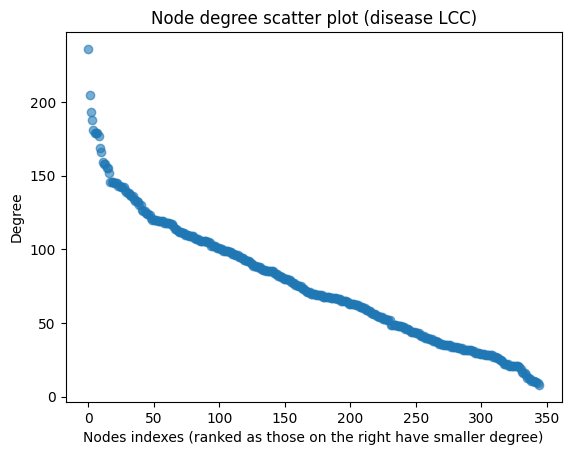

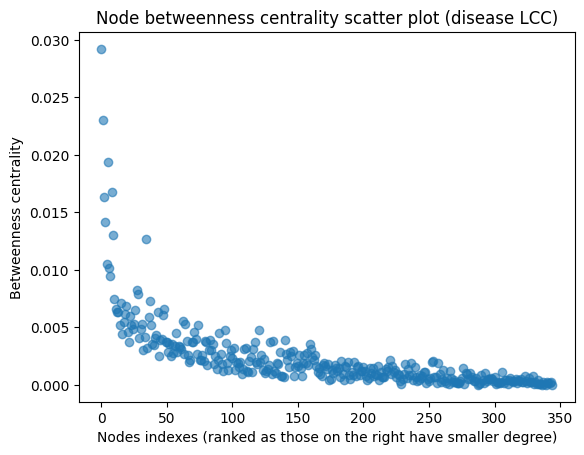

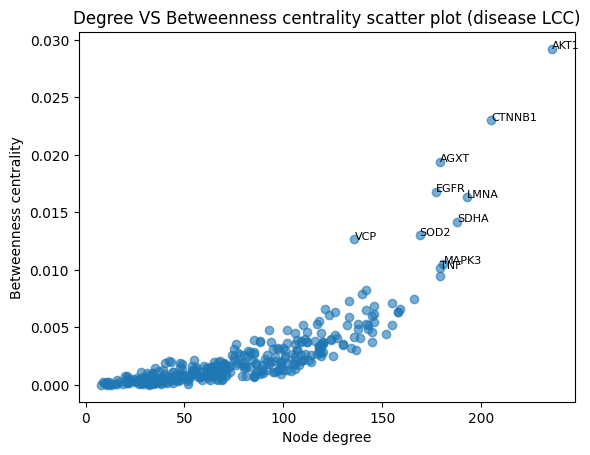

In [149]:
degree_values = [d for d in metrics_largest_LCC['degree'].tolist()]
betweenness_values = [d for d in metrics_largest_LCC['betweenness'].tolist()]

plt.scatter(range(len(degree_values)), degree_values, alpha=0.6)
plt.xlabel("Nodes indexes (ranked as those on the right have smaller degree)")
plt.ylabel("Degree")
plt.title("Node degree scatter plot (disease LCC)")
plt.show()

plt.scatter(range(len(betweenness_values)), betweenness_values, alpha=0.6)
plt.xlabel("Nodes indexes (ranked as those on the right have smaller degree)")
plt.ylabel("Betweenness centrality")
plt.title("Node betweenness centrality scatter plot (disease LCC)")
plt.show()

plt.scatter(degree_values, betweenness_values, alpha=0.6)
for node in metrics_largest_LCC['Node']:
    if betweenness[node] > 0.01:
        plt.text(degrees[node], betweenness[node], node, fontsize=8)
plt.xlabel("Node degree")
plt.ylabel("Betweenness centrality")
plt.title("Degree VS Betweenness centrality scatter plot (disease LCC)")
plt.show()

As we can see, there is a correlation between node degree and betweenness centrality. The more connected is the node, the geater is the betweenness centrality.

Betweenness centrality is the measure of how much a node is a "bridge/bottleneck" in other node pathways.

The most interesting nodes would be those with low degree and high betweenness ! Unfortunately here this scenario is doesn't appear. Maybe for VCP gene but not enough evidence...

## 2. Comparative analysis of disease genes identification algorithms

In [103]:
# TODO (Thomas)

## 3. Putative disease gene identification

In [102]:
# TODO (Stella ?)

## 4. Drug repurposing

In [101]:
# TODO (Annet ?)